## Network with multi-period battery dispatch

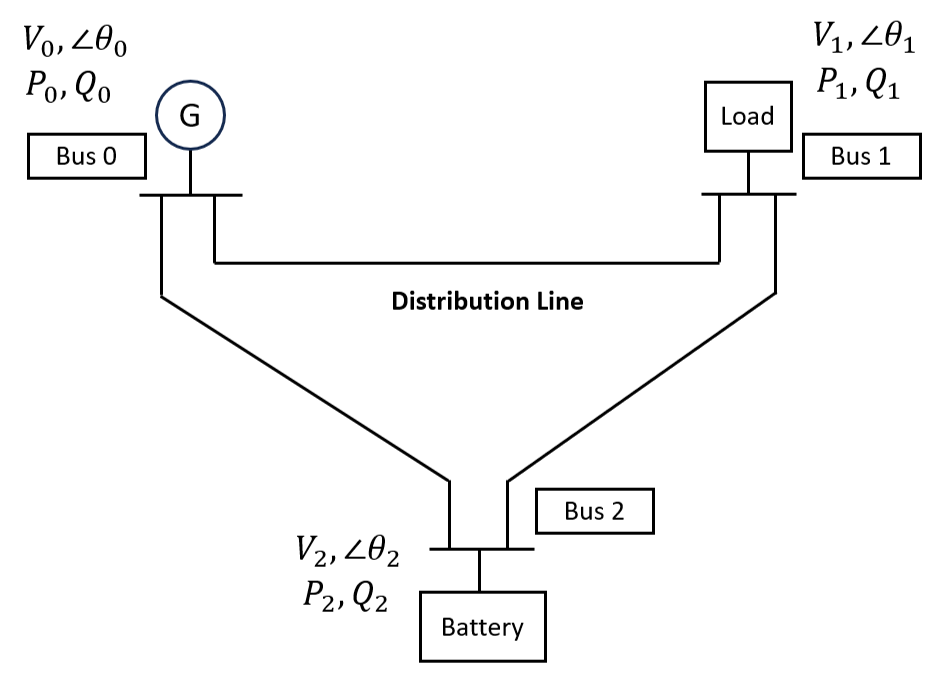

In [1]:
pip install pypsa

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U pypsa

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### Build Network Model

In [3]:
import numpy as np
import pandas as pd
import pypsa

n = pypsa.Network()

# 24 hourly snapshots
snapshots = pd.date_range("2025-01-01 00:00", periods=24, freq="h")
n.set_snapshots(snapshots)

# Carrier
n.add("Carrier", "AC")

# 8 buses
for i in range(8):
    n.add("Bus", f"Bus {i}", v_nom=400.0, carrier="AC")

# Lines: ring + two diagonals
line_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (4, 5), (5, 6), (6, 7), (7, 0),  # ring
    (2, 6), (3, 7)                   # diagonals
]
for idx, (bus0, bus1) in enumerate(line_connections):
    n.add("Line", f"Line {idx}",
          bus0=f"Bus {bus0}",
          bus1=f"Bus {bus1}",
          x=0.1, r=0.01, s_nom=100, carrier="AC")

# Generators (fixed capacities, committable)
gen_buses = [0, 1, 2, 3, 4, 5]
gen_costs = [10, 12, 18, 13, 20, 15]
gen_pom = [500,400,410,440,600,485]

for i, (bus, cost, pow) in enumerate(zip(gen_buses, gen_costs,gen_pom)):
    n.add("Generator", f"Gen {i}",
          bus=f"Bus {bus}",
          p_nom=pow,
          p_min_pu=0,
          p_mx_pu=1,
          sign=1,
          marginal_cost=cost,
          control="PV")

# Loads
load_data = {
    "Load A": ("Bus 6", 60),
    "Load B": ("Bus 7", 70),
    "Load C": ("Bus 3", 300)
}
for name, (bus, p_val) in load_data.items():
    n.add("Load", name, bus=bus, p_set=p_val)

# Storage units
storage_data = {
    "Storage 1": "Bus 5",
    "Storage 2": "Bus 6",
    "Storage 3": "Bus 7"
}

# Add batteries
for name, bus in storage_data.items():
    n.add("StorageUnit", name,
          bus=bus,
          p_nom=400,
          efficiency_store=0.9,
          efficiency_dispatch=0.9,
          max_hours=2,                    # 50 MW * 2 h = 100 MWh capacity
          state_of_charge_initial=800,    # 100% of capacity
          marginal_cost=0.01,                # cost on discharge
          marginal_cost_quadratic=0.5,       # convex QP term (HiGHS supports)
          capital_cost=0)


# Solve (QP with HiGHS)

res = n.optimize()


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1536 duals
Objective: 1.17e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


### Display the output - Generator and Battery

In [4]:

# ---------------------------
# Results (with small-negative clipping for readability)
# ---------------------------
def clip_small(df, tol=1e-6):
    out = df.copy()
    out[(out.abs() < tol)] = 0.0
    return out

print("\n=== Generator Active Power Outputs (MW) ===")
pg = clip_small(n.generators_t.p)
print(pg)

print("\n=== Storage Power (MW, +discharge, -charge) ===")
ps = clip_small(n.storage_units_t.p)
print(ps)

print("\n=== Storage State of Charge (MWh) ===")
print(n.storage_units_t.state_of_charge)



=== Generator Active Power Outputs (MW) ===
Generator                 Gen 0  Gen 1  Gen 2       Gen 3  Gen 4  Gen 5
snapshot                                                               
2025-01-01 00:00:00  148.718330    0.0    0.0  241.706672    0.0    0.0
2025-01-01 01:00:00  148.718312    0.0    0.0  241.706951    0.0    0.0
2025-01-01 02:00:00  148.718295    0.0    0.0  241.707225    0.0    0.0
2025-01-01 03:00:00  148.718279    0.0    0.0  241.707494    0.0    0.0
2025-01-01 04:00:00  148.718262    0.0    0.0  241.707758    0.0    0.0
2025-01-01 05:00:00  148.718246    0.0    0.0  241.708016    0.0    0.0
2025-01-01 06:00:00  148.718230    0.0    0.0  241.708269    0.0    0.0
2025-01-01 07:00:00  148.718215    0.0    0.0  241.708517    0.0    0.0
2025-01-01 08:00:00  148.718200    0.0    0.0  241.708760    0.0    0.0
2025-01-01 09:00:00  148.718185    0.0    0.0  241.708997    0.0    0.0
2025-01-01 10:00:00  148.718171    0.0    0.0  241.709229    0.0    0.0
2025-01-01 11:00:00

### Plot the output - Generator and Battery

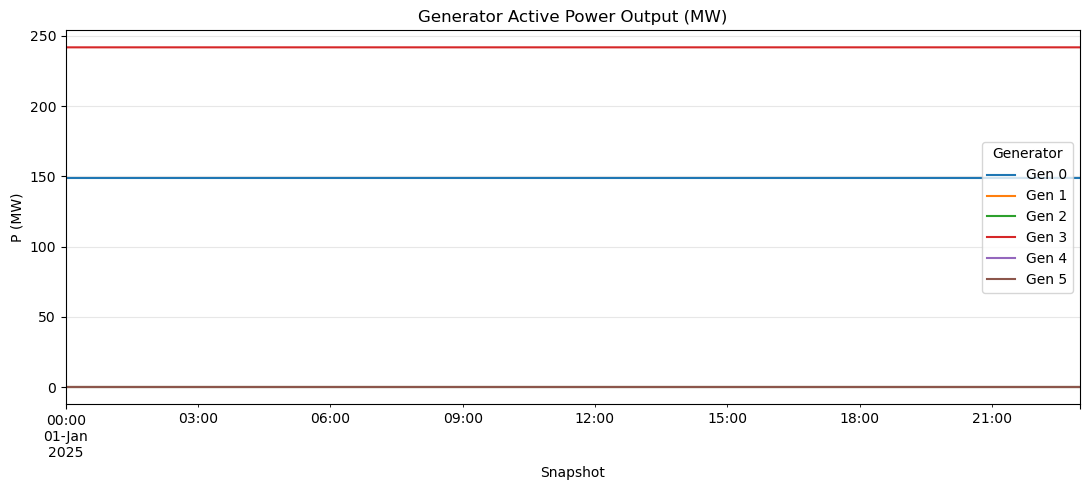

In [5]:
import matplotlib.pyplot as plt

# pg already defined via: pg = clip_small(n.generators_t.p)
fig, ax = plt.subplots(figsize=(11,5))
pg.plot(ax=ax)
ax.set_title("Generator Active Power Output (MW)")
ax.set_xlabel("Snapshot")
ax.set_ylabel("P (MW)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()


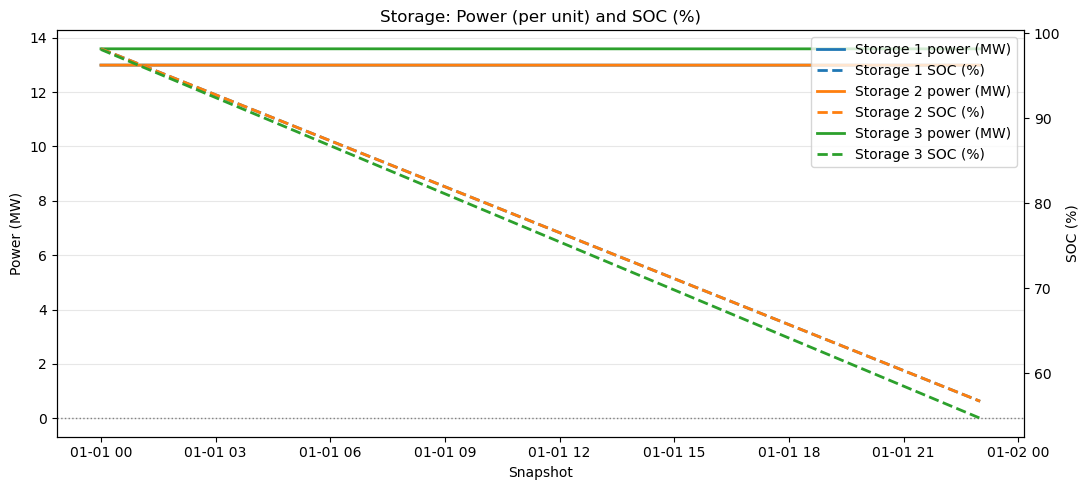

In [6]:

ps = n.storage_units_t.p

# Define SOC time series
soc = n.storage_units_t.state_of_charge

# Capacity per unit (MWh)
if "state_of_charge_nom" in n.storage_units.columns:
    cap = n.storage_units["state_of_charge_nom"]
else:  # fallback for older PyPSA
    cap = n.storage_units["p_nom"] * n.storage_units.get("max_hours", 1.0)

# Align columns (just in case)
units = n.storage_units.index
ps = ps.reindex(columns=units)
soc = soc.reindex(columns=units)
cap = cap.reindex(units)

# SOC % per unit
soc_pct_per_unit = soc.divide(cap, axis=1) * 100

# ---- Plot: per-unit power (left) and SOC% (right) with matching colors ----
fig, ax1 = plt.subplots(figsize=(11, 5))
ax2 = ax1.twinx()

# color cycle
from itertools import cycle
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

handles = []
labels = []

for unit, color in zip(units, colors):
    # Power (solid)
    h1 = ax1.plot(ps.index, ps[unit], label=f"{unit} power (MW)", color=color, linewidth=2)[0]
    # SOC% (dashed) with same color
    h2 = ax2.plot(soc_pct_per_unit.index, soc_pct_per_unit[unit],
                  label=f"{unit} SOC (%)", color=color, linestyle="--", linewidth=2)[0]
    handles += [h1, h2]
    labels  += [h1.get_label(), h2.get_label()]

ax1.axhline(0, linestyle=":", linewidth=1, color="gray")
ax1.set_title("Storage: Power (per unit) and SOC (%)")
ax1.set_xlabel("Snapshot")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("SOC (%)")

# Make axes a bit clearer
ax1.grid(True, which="both", axis="y", alpha=0.3)

# One combined legend
ax1.legend(handles, labels, loc="upper right", frameon=True)
plt.tight_layout()



### Cost Breakdown - Generator and Battery

In [7]:
# ---------------------------
# Cost breakdown
# ---------------------------
# 1) Calling statistics function
try:
    g = n.statistics.groupers
    print("\n=== OPEX by asset (Generators & StorageUnit) via n.statistics ===")
    opex_assets = n.statistics.opex(
        comps=["Generator", "StorageUnit"],
        groupby=g.name
    ).sort_values()
    print(opex_assets)

    print("\n=== OPEX by component & carrier ===")
    print(n.statistics.opex(groupby=["Component", "carrier"]))

    print("\n=== System cost (capex + opex) ===")
    print(n.statistics.system_cost(aggregate_groups="sum"))
except Exception as e:
    print("\n[Info] n.statistics not available or older PyPSA version. Falling back to manual calc.")
    
    # 2) Manual check (linear + quadratic). Note: StorageUnit cost applies to discharge only.
    w = n.snapshot_weightings["objective"]  # hours in objective (usually 1 per hour)
    # Generators
    pg_mwh = n.generators_t.p.mul(w, axis=0)  # MWh
    gen_lin = pg_mwh.multiply(n.generators.marginal_cost, axis=1).sum()
    gen_quad = (pg_mwh**2).multiply(
        n.generators.get("marginal_cost_quadratic", pd.Series(0.0, index=n.generators.index)),
        axis=1
    ).sum()
    gen_opex = gen_lin + gen_quad

    # Storage (discharge only is costed for StorageUnit)
    # The su_opex = ax(lin cost) + bx^2(quadratic cost)
    ps_discharge_mwh = n.storage_units_t.p.clip(lower=0).mul(w, axis=0)  # MWh
    su_lin = ps_discharge_mwh.multiply(n.storage_units.marginal_cost, axis=1).sum()
    su_quad = (ps_discharge_mwh**2).multiply(
        n.storage_units.get("marginal_cost_quadratic", pd.Series(0.0, index=n.storage_units.index)),
        axis=1
    ).sum()
    su_opex = su_lin + su_quad

    print("\n=== Manual OPEX (Generators) ===")
    print(gen_opex)
    print("\n=== Manual OPEX (StorageUnit, discharge costs) ===")
    print(su_opex)



=== OPEX by asset (Generators & StorageUnit) via n.statistics ===

[Info] n.statistics not available or older PyPSA version. Falling back to manual calc.

=== Manual OPEX (Generators) ===
Generator
Gen 0    3.569236e+04
Gen 1    2.585702e-11
Gen 2    1.136696e-11
Gen 3    7.541335e+04
Gen 4    2.842171e-13
Gen 5   -6.038477e-13
dtype: float64

=== Manual OPEX (StorageUnit, discharge costs) ===
StorageUnit
Storage 1    2028.250058
Storage 2    2028.250267
Storage 3    2219.776093
dtype: float64


### Unit Commitment of Generator

In [8]:
# ---------- Derive "unit commitment" (UC) from economic dispatch ----------

# Anything above a tiny threshold counts as ON
UC_THRESHOLD = 1e-3  # MW
UC = (pg > UC_THRESHOLD).astype(int)           # 1 = on, 0 = off
start_up  = ((UC == 1) & (UC.shift(fill_value=0) == 0)).astype(int)
shut_down = ((UC == 0) & (UC.shift(fill_value=0) == 1)).astype(int)

print("\n=== Derived UC (1=on, 0=off) ===")
print(UC)

print("\n=== Derived start-ups (1=start at this snapshot) ===")
print(start_up)

print("\n=== Derived shut-downs (1=stop at this snapshot) ===")
print(shut_down)

# ---------- Useful per‑generator summary ----------
def longest_on_streak(s: pd.Series) -> int:
    # longest consecutive run of 1s in a 0/1 series
    blocks = (s != s.shift()).cumsum()
    return s.groupby(blocks).sum().max()

summary = pd.DataFrame({
    "on_hours": UC.sum(),
    "starts": start_up.sum(),
    "shutdowns": shut_down.sum(),
    "max_consecutive_on": UC.apply(longest_on_streak),
    "avg_output_when_on_MW": pg.where(UC == 1).mean(),
    "capacity_MW": n.generators.p_nom
})
print("\n=== UC summary by generator ===")
print(summary.sort_index())


=== Derived UC (1=on, 0=off) ===
Generator            Gen 0  Gen 1  Gen 2  Gen 3  Gen 4  Gen 5
snapshot                                                     
2025-01-01 00:00:00      1      0      0      1      0      0
2025-01-01 01:00:00      1      0      0      1      0      0
2025-01-01 02:00:00      1      0      0      1      0      0
2025-01-01 03:00:00      1      0      0      1      0      0
2025-01-01 04:00:00      1      0      0      1      0      0
2025-01-01 05:00:00      1      0      0      1      0      0
2025-01-01 06:00:00      1      0      0      1      0      0
2025-01-01 07:00:00      1      0      0      1      0      0
2025-01-01 08:00:00      1      0      0      1      0      0
2025-01-01 09:00:00      1      0      0      1      0      0
2025-01-01 10:00:00      1      0      0      1      0      0
2025-01-01 11:00:00      1      0      0      1      0      0
2025-01-01 12:00:00      1      0      0      1      0      0
2025-01-01 13:00:00      1      0   

### Voltage Magnitude on Each Bus

In [9]:

# 1) Freeze OPF dispatch as PF setpoints
# -----------------------------
# Generators: use OPF P as p_set for PF
n.generators_t.p_set = n.generators_t.p.copy()

# 2) Include storage injections in PF
#    p > 0 = discharge (injection), p < 0 = charging (withdrawal)
# -----------------------------
_tmp_su_gens = []
for su in n.storage_units.index:
    tmpg = f"_SUinj_{su}"
    _tmp_su_gens.append(tmpg)
    bus = n.storage_units.at[su, "bus"]
    # Big enough nameplate so we don't bind
    n.add("Generator", tmpg, bus=bus, p_nom=1e6, control="PQ")
    # Ensure a p_set column exists then fill with the OPF dispatch
    if tmpg not in n.generators_t.p_set.columns:
        n.generators_t.p_set[tmpg] = 0.0
    n.generators_t.p_set[tmpg] = n.storage_units_t.p[su]

# 3) Choose bus types for PF

# -----------------------------
# Pick a slack generator (e.g., the cheapest Gen 5)

slack_gen = "Gen 5" if "Gen 5" in n.generators.index else n.generators.index[0]

n.generators["slack"] = False
n.generators.loc[:, "control"] = "PQ"
n.generators.at[slack_gen, "slack"] = True
n.generators.at[slack_gen, "control"] = "Slack"
n.generators.at[slack_gen, "v_set"] = 1.0   # pu at slack bus

# For completeness, set reactive setpoints for PQ gens to 0
n.generators_t.q_set = pd.DataFrame(
    0.0, index=n.snapshots, columns=n.generators.index
)

# -----------------------------
# 4) Run AC power flow across all snapshots
# -----------------------------
n.pf()   # Newton-Raphson PF over n.snapshots

# -----------------------------
# 5) Inspect voltages
# -----------------------------
print("\n=== Bus voltage magnitudes |V| (pu) ===")
print(n.buses_t.v_mag_pu)

# Quick health checks
vmin = n.buses_t.v_mag_pu.min(axis=1).rename("Vmin_pu")
vmax = n.buses_t.v_mag_pu.max(axis=1).rename("Vmax_pu")
print("\n=== Per-snapshot voltage envelope (min/max pu) ===")
print(pd.concat([vmin, vmax], axis=1))

# Example: flag snapshots violating +10% / -6% limits
viol = (vmin < 0.94) | (vmax > 1.10)
if viol.any():
    print("\nSnapshots with voltage violations (Vmin<0.94 or Vmax>1.10):")
    print(viol[viol].index.tolist())



INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000002B7A4E2BB10> for snapshots DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00',
               '2025-01-01 10:00:00', '2025-01-01 11:00:00',
               '2025-01-01 12:00:00', '2025-01-01 13:00:00',
               '2025-01-01 14:00:00', '2025-01-01 15:00:00',
               '2025-01-01 16:00:00', '2025-01-01 17:00:00',
               '2025-01-01 18:00:00', '2025-01-01 19:00:00',
               '2025-01-01 20:00:00', '2025-01-01 21:00:00',
               '2025-01-01 22:00:00', '2025-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')



=== Bus voltage magnitudes |V| (pu) ===
Bus                     Bus 0     Bus 1     Bus 2     Bus 3  Bus 4  Bus 5  \
snapshot                                                                    
2025-01-01 00:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 01:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 02:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 03:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 04:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 05:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 06:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 07:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 08:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 09:00:00  1.000007  1.000004  1.000001  0.999999    1.0    1.0   
2025-01-01 10:00:00  1.000007  1.00

### Visualisation of Voltage Magnitude


Snapshots with any violation:
[]

Per-bus violation counts (descending):
Bus
Bus 0    0
Bus 1    0
Bus 2    0
Bus 3    0
Bus 4    0
Bus 5    0
Bus 6    0
Bus 7    0
dtype: int64


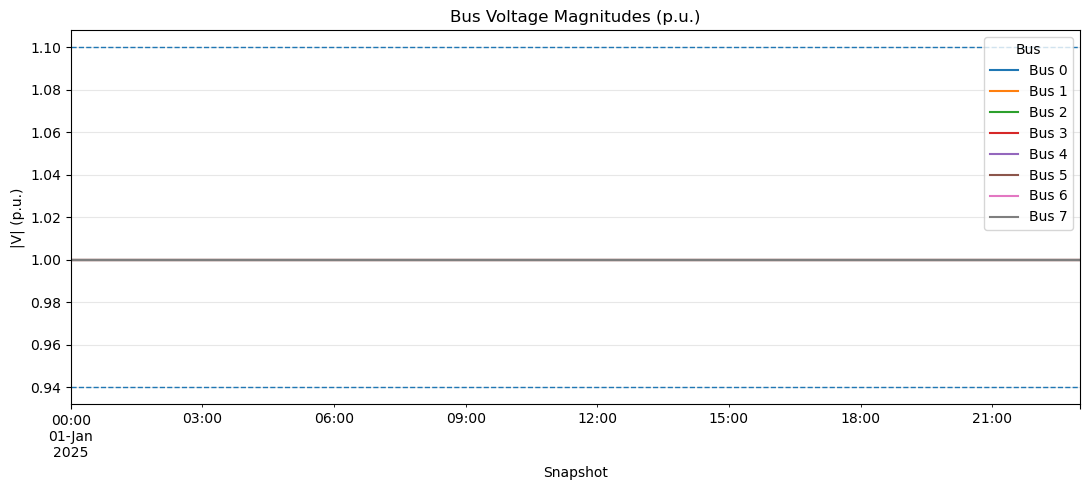

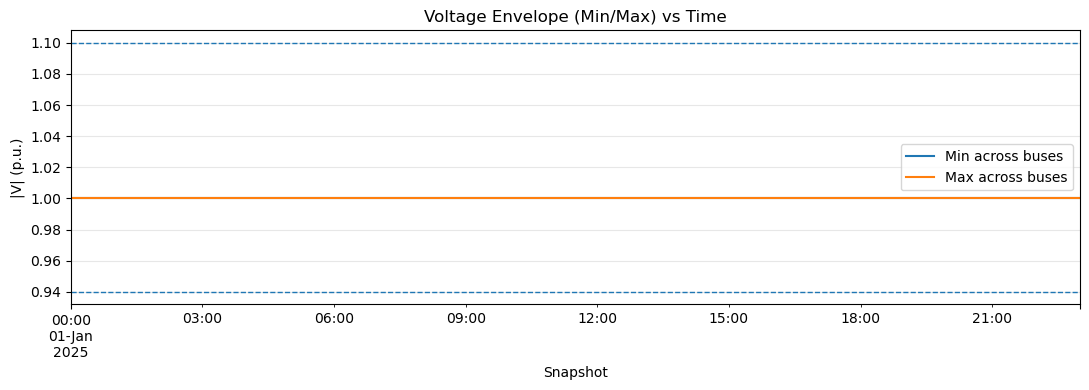

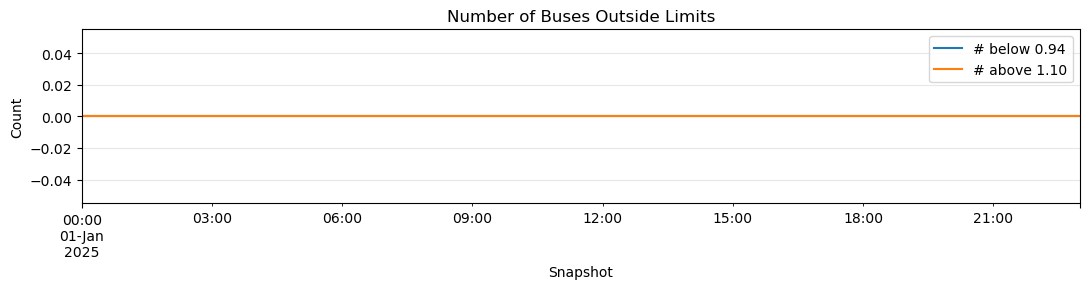

In [10]:
import matplotlib.pyplot as plt

V = n.buses_t.v_mag_pu.copy()           # |V| per bus over time (pu)
vmin = V.min(axis=1).rename("Vmin")
vmax = V.max(axis=1).rename("Vmax")

# -----------------------------
# 1) Per-bus voltage traces
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 5))
V.plot(ax=ax, legend=True)
ax.axhline(1.10, linestyle="--", linewidth=1)  # +10% line
ax.axhline(0.94, linestyle="--", linewidth=1)  # -6% line
ax.set_title("Bus Voltage Magnitudes (p.u.)")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 2) Voltage envelope (min/max across buses)
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 4))
vmin.plot(ax=ax, label="Min across buses")
vmax.plot(ax=ax, label="Max across buses")
ax.axhline(1.10, linestyle="--", linewidth=1)
ax.axhline(0.94, linestyle="--", linewidth=1)
ax.legend()
ax.set_title("Voltage Envelope (Min/Max) vs Time")
ax.set_xlabel("Snapshot")
ax.set_ylabel("|V| (p.u.)")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# 3) Count how many buses violate limits at each snapshot
# -----------------------------
below = (V < 0.94).sum(axis=1).rename("# below 0.94")
above = (V > 1.10).sum(axis=1).rename("# above 1.10")

fig, ax = plt.subplots(figsize=(11, 3))
below.plot(ax=ax)
above.plot(ax=ax)
ax.legend()
ax.set_title("Number of Buses Outside Limits")
ax.set_xlabel("Snapshot")
ax.set_ylabel("Count")
ax.grid(True, which="both", axis="y", alpha=0.3)
plt.tight_layout()

# -----------------------------
# (Optional) quick text summaries
# -----------------------------
print("\nSnapshots with any violation:")
viol = (V.lt(0.94) | V.gt(1.10)).any(axis=1)
print(viol[viol].index.tolist())

print("\nPer-bus violation counts (descending):")
per_bus_viol = (V.lt(0.94) | V.gt(1.10)).sum().sort_values(ascending=False)
print(per_bus_viol)
